## Deep Learning Multiclassifier Basics

In this notebook I take the famous MNIST Dataset and implement a simple but powefull Convolutional Neural Network, with 99% Test Acc. and with the ability to be used in applications outside the MNIST Dataset.

I used the Keras library to develop the NN.

The MNIST Dataset is a classical dataset in Computer Vision, made of handwritten digits. So, in this task I try to develop a Classifier to predict handwritten digits from 0 to 9.

A lot of the core ideas here came after I read "Deep Learning with Python" by François Chollet. A great book for those who want to learn Keras and Deep Learning.

In [2]:
# Imports
# For modelling
from keras.datasets import mnist
from keras.models import load_model
from keras.utils import to_categorical
from keras import layers, models
import numpy as np

# To plot
import matplotlib.pyplot as plt

# For handling images
import cv2

/home/andre/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## The data

Each sample in the dataset is a 28x28 image with one colour channel. You can see an example below.
The data is splitted into 60000 train samples and 10000 test samples.
The classes are well balanced trough the dataset.

Digit Sample


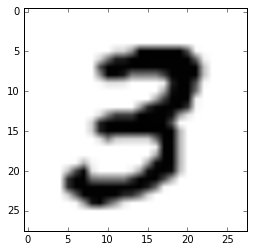

In [2]:
# Importing the data, already available in the Keras package
(train_images_total, train_labels_total), (test_images, test_labels) = mnist.load_data()

print('Digit Sample')
example = train_images_total[7]
plt.imshow(example, cmap=plt.cm.binary)

## Convnet Model

For the model's architecture I chose a Convolutional Neural Network.
The model is sequential, composed by 8 layers:
    - 2 pairs of Convolution + MaxPooling Layers
    - Convolution Layer
    - Flatten Layer, to reshape the data in 1 dimension
    - A Dense layer
    - Final Dense layer with ten final nodes, the same as the number of classes in our problem
    
For the activation function in the layers I used relu, except in the last one where I used the softmax to output the index for the max value in the predicitions. This will be our digit predicted.
I used RMSprop optimizer, a standard optimizer.
The Loss Function will be the Categorical Crossentropy, because we are dealing with a multiclassification problem.
I used Accuracy as performance metric because we have a balanced dataset.

I kept a validation set for tunning the model, that I first trained with 13 epochs.

In [3]:
# Data Processing
train_images_total = train_images_total.reshape((60000, 28, 28, 1)) # reshape to match NN input
train_images_total = train_images_total.astype('float32') / 255  # normalization of gray images
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels_total = to_categorical(train_labels_total)  # one hot encoding
test_labels = to_categorical(test_labels)

num_validation_samples = 12500
validation_data = train_images_total[: num_validation_samples]
validation_labels = train_labels_total[: num_validation_samples]
train_data = train_images_total[num_validation_samples :]

train_labels = train_labels_total[num_validation_samples :]

In [4]:
# Modelling
model = models.Sequential()
# Convolution NN part
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

# Classifier Part
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Tunning the model
model.compile(optimizer='rmsprop',  # a standard optimizer
              loss='categorical_crossentropy',  # the suitable for multiclass classifiers
              metrics=['accuracy'])  # suitable for a balanced dataset has the one we have
history = model.fit(train_data, train_labels, epochs=13, batch_size=512,
                    validation_data=[validation_data, validation_labels])
# Monitor the Loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']                      

Train on 47500 samples, validate on 12500 samples
Epoch 1/13
47500/47500 [==============================] - 45s 953us/step - loss: 0.6114 - acc: 0.8102 - val_loss: 0.2434 - val_acc: 0.9275
Epoch 2/13
47500/47500 [==============================] - 40s 847us/step - loss: 0.1585 - acc: 0.9511 - val_loss: 0.1083 - val_acc: 0.9654
Epoch 3/13
47500/47500 [==============================] - 40s 848us/step - loss: 0.0960 - acc: 0.9704 - val_loss: 0.0768 - val_acc: 0.9762
Epoch 4/13
47500/47500 [==============================] - 40s 849us/step - loss: 0.0644 - acc: 0.9793 - val_loss: 0.0926 - val_acc: 0.9718
Epoch 5/13
47500/47500 [==============================] - 46s 960us/step - loss: 0.0502 - acc: 0.9839 - val_loss: 0.0572 - val_acc: 0.9818
Epoch 6/13
47500/47500 [==============================] - 48s 1ms/step - loss: 0.0406 - acc: 0.9874 - val_loss: 0.0526 - val_acc: 0.9841
Epoch 7/13
47500/47500 [==============================] - 46s 970us/step - loss: 0.0336 - acc: 0.9894 - val_loss: 0.06

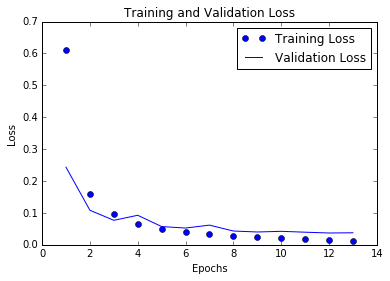

In [5]:
# Plotting the Performance on each epoch
epochs = range(1, 14)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Validation

We can see that the model starts to overfit in the training data after the 7th epoch, where the Validation Loss stabilizes.
So I'll train the final model in 7 epochs using the whole training data.

In [6]:
final_model = model
final_model.fit(train_images_total, train_labels_total, epochs=7, batch_size=512)
test_loss, test_acc = final_model.evaluate(test_images, test_labels)
print('Test Acc.: {0}%'.format(round(test_acc, 2) * 100))

final_model.save('mnist_final.h5')  # saving the model

Epoch 1/7
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0174 - acc: 0.9947
Epoch 2/7
60000/60000 [==============================] - 52s 871us/step - loss: 0.0143 - acc: 0.9957
Epoch 3/7
60000/60000 [==============================] - 51s 843us/step - loss: 0.0120 - acc: 0.9962
Epoch 4/7
60000/60000 [==============================] - 51s 856us/step - loss: 0.0093 - acc: 0.9971
Epoch 5/7
60000/60000 [==============================] - 56s 938us/step - loss: 0.0086 - acc: 0.9972
Epoch 6/7
60000/60000 [==============================] - 60s 1ms/step - loss: 0.0071 - acc: 0.9978
Epoch 7/7
10000/10000 [==============================] - 2s 192us/step
Test Acc.: 99.0%


## Results

99% Accuracy is great, especially with such a few lines of code for modelling. Thanks Keras for that!

Now let's see if the model is good for classifying arbitrary data, for that I'll use it in a digit handwritten by myself.

Prediction: 5


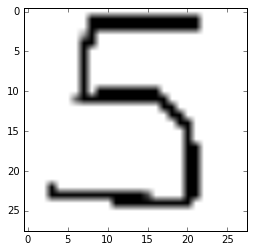

In [4]:
im_gray = cv2.imread('digit_test.png', cv2.IMREAD_GRAYSCALE)
thresh = 127
im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
im_bw = cv2.resize(im_bw, (28, 28))
im_bw = (255 - im_bw)
im_bw = im_bw.astype('float32') / 255
plt.imshow(im_bw, cmap=plt.cm.binary)
final_model = load_model('mnist_final.h5')
test_prediction = final_model.predict(im_bw.reshape(1,28,28,1))
digit_predicition = np.argmax(test_prediction)
print('Prediction: {0}'.format(digit_predicition))

## Great!

It works well, feel free to try it yourself!